# 百货商场用户画像描述与价值分析

## 1 内容概述

### 本项目内容主要是基于Python的“百货商场用户画像描述与价值分析”，有详细的数据预处理、数据可视化和数据建模等步骤。同时，针对传统RFM模型进行了改进，构造了LRFMP模型来分析客户价值，挖掘客户价值的八个字段，并通过词云形式展现了出来，可以对会员用户进行精准画像。

## 2 背景描述

### 数据集分为两部分，cumcm2018c1.xlsx是会员信息表，cumcm2018c2.csv是销售流水表。其中，会员信息表共有将近19万条记录，销售流水表共有接近189万条记录，其包括2015-01-01到2018-01-03之间所产生的数据。

## 3 数据说明

### 两个表包含了如会员卡号，消费产生时间，性别，出生时间，商品编码，销售数量，商品售价，消费金额，商品名称，此次消费的会员积分，收银机号，单据号，柜组编码，柜组名称，等级时间等 15 个特征。

## 4 数据来源

### 数据源来自泰迪公司提供的百货商店会员数据。

## 5 实现目标

### 本项目主要围绕着“百货商店会员用户画像描绘与价值分析”内容进行，结合目前百货商场的数据情况，可以实现以下目标：

### ·借助百货商场会员用户数据，对会员用户进行分群。
### ·对不同的会员用户类别进行特征分析，比较不同类别会员用户的会员用户价值。
### ·对不同价值的会员用户类别提供个性化服务，制定相应的营销策略。

## 6 LRFMP字段说明

### L（入会程度）：3个月以下为新用户，4-12个月为中等用户，13个月以上为老用户
### R（最近购买的时间）
### F（消费频次）：次数20次以上的为高频消费，6-19次为中频消费，5次以下为低频消费
### M（消费金额）：10万以上为高等消费，1万-10万为中等消费，1万以下为低等消费
### P（消费积分）：10万以上为高等积分用户，1万-10万为中等积分用户，1万以下为低等积分用户

In [4]:
import matplotlib
import warnings
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({'font.size' : 16})
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# 任务1 项目背景

## 任务1.1 项目背景与挖掘目标

In [8]:
# 查看会员信息表
df_cum = pd.read_excel('cumcm2018c1.xlsx')
df_cum.head()

,会员卡号,出生日期,性别,登记时间
0,c68b20b4,2002-11-02 00:00:00,0.0,2013-05-11 00:00:00.000
1,1ca15332,NaN,0.0,2004-11-04 16:31:52.436
2,a37cc182,1967-02-17 00:00:00,0.0,2004-12-31 21:24:34.216
3,2ab88539,1982-06-01 00:00:00,0.0,2010-11-19 00:00:00.000
4,b4c77269,1964-02-05 00:00:00,0.0,2007-12-14 00:00:00.000


In [9]:
# 查看销售流水表
df_sale = pd.read_csv('./cumcm2018c2.csv', encoding = 'utf8')
df_sale.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,收银机号,单据号,柜组编码,柜组名称
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,6,25bb,8077.0,兰芝柜
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,6,25bb,8077.0,兰芝柜
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,6,25bb,8077.0,兰芝柜
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,6,25bb,8077.0,兰芝柜
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,6,25bb,8077.0,兰芝柜


# 任务2 数据探索与预处理

## 任务2.1 结合业务对数据进行探索并进行预处理

### 会员信息表数据探索与预处理

In [14]:
# 先来对会员信息表进行分析
print('会员信息表一共有{}行记录，{}列字段'.format(df_cum.shape[0], df_cum.shape[1]))
print('数据缺失的情况为：\n{}'.format(df_cum.isnull().mean()))
print('会员卡号（不重复）有{}条记录'.format(len(df_cum['会员卡号'].unique())))

会员信息表一共有194760行记录，4列字段
数据缺失的情况为：
会员卡号    0.000000
出生日期    0.175539
性别      0.048444
登记时间    0.065126
dtype: float64
会员卡号（不重复）有194754条记录


从上面可以简要看出，数据中会员卡号存在一些重复值，且会员入会登记时间都有缺失，需要去重去缺失值，因为性别比例缺失较少，故用众数来填补性别上的缺失值

In [15]:
# 会员信息表去重
df_cum.drop_duplicates(subset = '会员卡号', inplace = True)
print('会员卡号（去重）有{}条记录'.format(len(df_cum['会员卡号'].unique())))

# 去除登记时间的缺失值，不能直接dropna，因为我们需要保留一定的数据集进行后续的LRFMP建模操作
df_cum.dropna(subset = ['登记时间'], inplace = True)
print('df_cum（去重和去缺失）有{}条记录'.format(df_cum.shape[0]))

会员卡号（去重）有194754条记录
df_cum（去重和去缺失）有182070条记录


In [16]:
# 性别上缺失的比例较少，所以下面采用众数填充的方法
df_cum['性别'].fillna(df_cum['性别'].mode().values[0], inplace = True)
df_cum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182070 entries, 0 to 194759
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   会员卡号    182070 non-null  object        
 1   出生日期    154474 non-null  object        
 2   性别      182070 non-null  float64       
 3   登记时间    182070 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.9+ MB


In [17]:
# 检验是否在“登记时间”这一字段上是否存在异常值，若存在异常值，则无法进行基础的运算操作，下面操作能正常执行，说明不存在异常值
df = df_cum['登记时间'] + pd.Timedelta(days = 1)
df.head()

0   2013-05-12 00:00:00.000
1   2004-11-05 16:31:52.436
2   2005-01-01 21:24:34.216
3   2010-11-20 00:00:00.000
4   2007-12-15 00:00:00.000
Name: 登记时间, dtype: datetime64[ns]

In [18]:
# 查看处理后数据缺失值情况
df_cum.isnull().mean()

会员卡号    0.000000
出生日期    0.151568
性别      0.000000
登记时间    0.000000
dtype: float64

In [19]:
# 由于出生日期这一列的缺失值过多，且存在较多的异常值，不能贸然删除
# 故下面另建一个数据集L来保存“出生日期”和“性别”信息，方便下面对会员的性别和年龄信息进行统计
L = pd.DataFrame(df_cum.loc[df_cum['出生日期'].notnull(), ['出生日期', '性别']])
L['年龄'] = L['出生日期'].astype(str).apply(lambda x: x[:3] + '0')
L.drop('出生日期', axis = 1, inplace = True)
L['年龄'].value_counts()

年龄
1980    47142
1970    43407
1960    26678
1750    16748
1990    11811
1950     7078
1940      893
2010      370
2000      139
1930      110
1920       32
1900       21
1910        8
1880        4
1890        3
1860        3
5220        2
1870        2
1760        2
1850        2
9790        1
1790        1
2640        1
1780        1
8500        1
8900        1
7710        1
5190        1
9740        1
1770        1
5010        1
2190        1
9820        1
9880        1
1820        1
8400        1
8700        1
9690        1
6200        1
Name: count, dtype: int64

In [20]:
# 出生日期这列值出现较多的异常值，以一个正常人寿命为100年算起，我们假定会员年龄范围在1920-2020之间，将超过该范围的值当作异常值进行剔除
L['年龄'] = L['年龄'].astype(int)
condition = "年龄 >= 1920 and 年龄 <= 2020"
L = L.query(condition)
L.index = range(L.shape[0])
L['年龄'].value_counts()

年龄
1980    47142
1970    43407
1960    26678
1990    11811
1950     7078
1940      893
2010      370
2000      139
1930      110
1920       32
Name: count, dtype: int64

In [21]:
# 用于与销售流水表进行合并的数据只取['会员卡号', '性别', '登记时间']这三列，将出生日期这列意义不大的进行删除（这列信息最有可能出错），并重置索引
df_cum.drop('出生日期', axis = 1, inplace = True)
df_cum.index = range(df_cum.shape[0])
print('数据清洗之后共有{}行记录，{}列字段，字段分别为{}'.format(df_cum.shape[0], df_cum.shape[1], df_cum.columns.tolist()))

数据清洗之后共有182070行记录，3列字段，字段分别为['会员卡号', '性别', '登记时间']


In [22]:
df_cum.head()

,会员卡号,性别,登记时间
0,c68b20b4,0.0,2013-05-11 00:00:00.000
1,1ca15332,0.0,2004-11-04 16:31:52.436
2,a37cc182,0.0,2004-12-31 21:24:34.216
3,2ab88539,0.0,2010-11-19 00:00:00.000
4,b4c77269,0.0,2007-12-14 00:00:00.000


### 销售流水表数据探索和预处理

In [23]:
df_sale.columns

Index(['会员卡号', '消费产生的时间', '商品编码', '销售数量', '商品售价', '消费金额', '商品名称', '此次消费的会员积分',
       '收银机号', '单据号', '柜组编码', '柜组名称'],
      dtype='object')

In [24]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893532 entries, 0 to 1893531
Data columns (total 12 columns):
 #   Column     Dtype  
---  ------     -----  
 0   会员卡号       object 
 1   消费产生的时间    object 
 2   商品编码       object 
 3   销售数量       int64  
 4   商品售价       float64
 5   消费金额       float64
 6   商品名称       object 
 7   此次消费的会员积分  float64
 8   收银机号       int64  
 9   单据号        object 
 10  柜组编码       float64
 11  柜组名称       object 
dtypes: float64(4), int64(2), object(6)
memory usage: 173.4+ MB


In [25]:
# 验证销售数量全部大于0
print('销售数量大于0的记录有：{}\t 全部记录有：{}\t 两者是否相等：{}'.format(len(df_sale['销售数量'] > 0), 
                                                     df_sale.shape[0], len(df_sale['销售数量'] > 0) == df_sale.shape[0]))

# 验证销售金额也全部大于0，说明两者不会对后者特征创造时产生影响
print('销售金额大于0的记录有：{}\t 全部记录有：{}\t 两者是否相等：{}'.format(len(df_sale['消费金额'] > 0), 
                                                     df_sale.shape[0], len(df_sale['消费金额'] > 0) == df_sale.shape[0]))

销售数量大于0的记录有：1893532	 全部记录有：1893532	 两者是否相等：True
销售金额大于0的记录有：1893532	 全部记录有：1893532	 两者是否相等：True


In [26]:
# 查看是否存在缺失值
df_sale.isnull().mean()

会员卡号         0.537348
消费产生的时间      0.000000
商品编码         0.000000
销售数量         0.000000
商品售价         0.000000
消费金额         0.000000
商品名称         0.000000
此次消费的会员积分    0.537348
收银机号         0.000000
单据号          0.000000
柜组编码         0.537348
柜组名称         0.547631
dtype: float64

In [27]:
# 会员信息表和销售流水表这两张表唯一相关联的字段便是“会员卡号”
# 由于销售流水表中“会员卡号”有将近一半为缺失值，这类数据无法进行填充，且后续需要对会员消费记录进行统计分析和建模，故只能舍弃
df_sale_clearn = df_sale.dropna(subset = ['会员卡号'])
df_sale_clearn.isnull().mean()

会员卡号         0.000000
消费产生的时间      0.000000
商品编码         0.000000
销售数量         0.000000
商品售价         0.000000
消费金额         0.000000
商品名称         0.000000
此次消费的会员积分    0.000000
收银机号         0.000000
单据号          0.000000
柜组编码         0.000000
柜组名称         0.022225
dtype: float64

可以看到，舍弃掉会员卡号缺失值之后，便只有柜组名称存在缺失，下面舍弃掉一些无意义的字段，仅保留对本项目有研究价值的字段信息

In [28]:
df_sale_clearn.drop(['收银机号', '柜组编码', '柜组名称'], axis = 1, inplace = True)
# 重置索引
df_sale_clearn.index = range(df_sale_clearn.shape[0])

In [29]:
type(df_sale_clearn) == type(df_cum)

True

## 任务2.2 将会员信息表和销售流水表关联与合并

In [30]:
# 重新查看一下各个数据集的长度
print(f'会员信息表中的记录为{len(df_cum)}\t销售流水表中的记录为{len(df_sale_clearn)}')

会员信息表中的记录为182070	销售流水表中的记录为876046


In [38]:
# 按照会员卡号将两张表里的信息进行合并，使用左连接合并，获得一个既包含会员信息，又包含非会员信息的数据
df = pd.merge(df_sale_clearn, df_cum, on = '会员卡号', how = 'left')
df

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,25bb,NaN,NaT
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,25bb,NaN,NaT
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,25bb,NaN,NaT
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,25bb,NaN,NaT
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,25bb,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...
876041,607c7cde,2018-01-03 21:38:15.343,c483e08b,1,200.0,200.00,植村秀眉笔4g,200.00,3d84,0.0,2017-09-02 19:44:50.123
876042,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,1.0,1.00,爱慕内衣正价件,1.00,7cd8,NaN,NaT
876043,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,490.0,490.00,爱慕内衣正价件,490.00,7cd8,NaN,NaT
876044,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,280.0,280.00,爱慕内衣正价件,280.00,7cd8,NaN,NaT


In [33]:
# 这里再次查看“消费金额”>0，“积分”>0，“销售数量”>0
index1 = df['消费金额'] > 0
index2 = df['此次消费的会员积分'] > 0
index3 = df['销售数量'] > 0
df1 = df.loc[index1 & index2 & index3, :]
df1.index = range(df1.shape[0])
df1.shape

(738462, 11)

这里可以看到，表合并之后的数据异常值突然变多了，这里就需要对此进行预处理，筛选掉那些异常值，方便后续进行分析

In [39]:
# 创造一个特征字段，判断是否为会员，1表示为会员，0表示不为会员
df1['会员'] = 1
df1.loc[df1['性别'].isnull(), '会员'] = 0
df1.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,会员
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,25bb,NaN,NaT,0
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,25bb,NaN,NaT,0
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,25bb,NaN,NaT,0
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,25bb,NaN,NaT,0
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,25bb,NaN,NaT,0


# 任务3 统计分析

## 任务3.1 分析会员的年龄构成、男女比例等基本信息

In [40]:
# 处理男女比例这一列，0表示女，1表示男
L['性别'] = L['性别'].apply(lambda x: '男' if x == 1 else '女')

In [41]:
sex_sort = L['性别'].value_counts()
sex_sort

性别
女    108283
男     29377
Name: count, dtype: int64

In [42]:
# 可以将年龄划分为老年（1920-1950）、中年（1960-1990）、青年（1990-2010），再重新绘制一个饼图，
L['年龄段'] = '中年'
L.loc[L['年龄'] <= 1950, '年龄段'] = '老年'
L.loc[L['年龄'] >= 1990, '年龄段'] = '青年'
res = L['年龄段'].value_counts()
res

年龄段
中年    117227
青年     12320
老年      8113
Name: count, dtype: int64

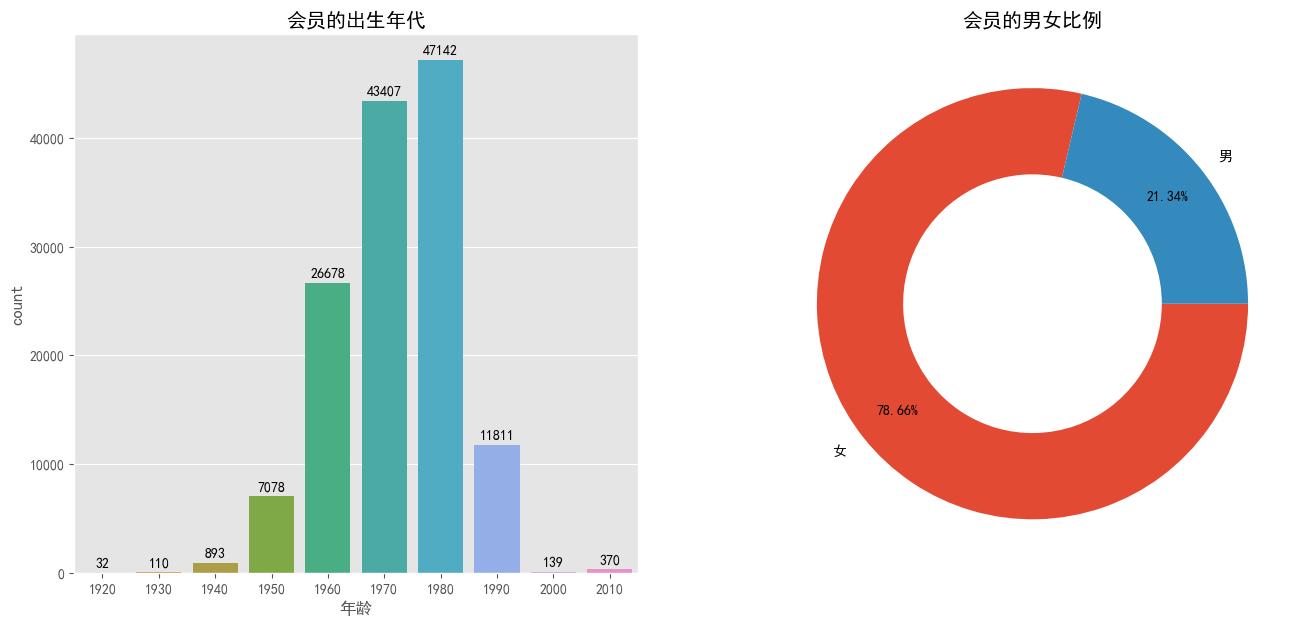

In [43]:
# 使用上述预处理后的数据集L，包含两个字段，分别是“年龄”和“性别”，先画出年龄的条形图
fig, axs = plt.subplots(1, 2, figsize = (16, 7), dpi = 100)
# 绘制条形图
ax = sns.countplot(x = '年龄', data = L, ax = axs[0])
# 设置数字标签
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + (p.get_width() / 2), y = height + 500, s = '{:.0f}'.format(height), ha = 'center')
axs[0].set_title('会员的出生年代')
# 绘制饼图
axs[1].pie(sex_sort, labels = sex_sort.index, wedgeprops = {'width': 0.4}, counterclock = False, autopct = '%.2f%%', pctdistance = 0.8)
axs[1].set_title('会员的男女比例')
plt.savefig('./会员出生年代及男女比例情况.png')

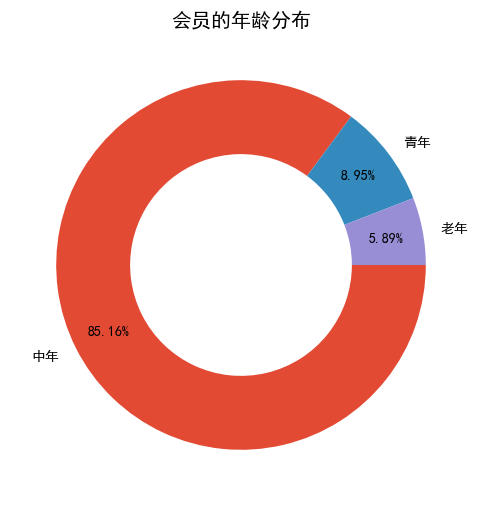

In [44]:
# 绘制各个年龄段的饼图
plt.figure(figsize = (8, 6), dpi = 100)
plt.pie(res.values, labels = ['中年', '青年', '老年'], autopct = '%.2f%%', pctdistance = 0.8, 
        counterclock = False, wedgeprops = {'width': 0.4})
plt.title('会员的年龄分布')
plt.savefig('./会员的年龄分布.png')

## 任务3.2 分析会员的总订单占比，总消费金额占比等消费情况

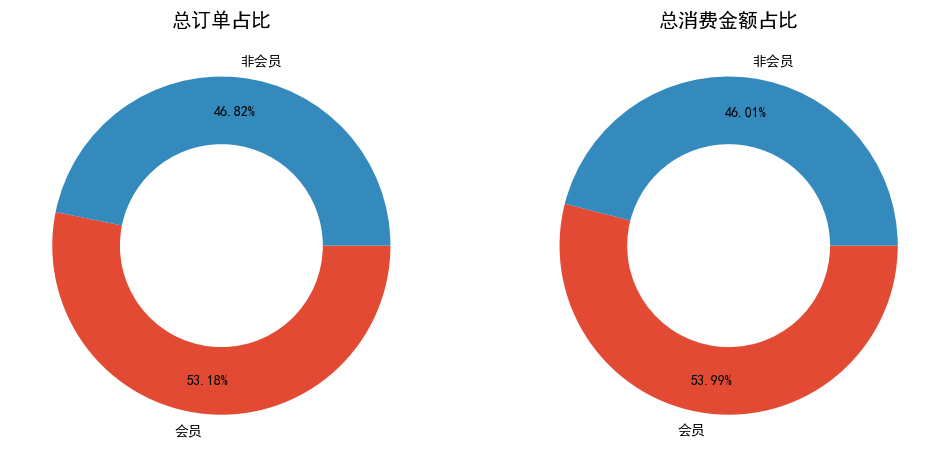

In [45]:
# 由于相同的单据号可能不是同一笔消费，以“消费产生的时间”为分组依据，我们可以知道有多少个不同的消费时间，即消费的订单数
fig, axs = plt.subplots(1, 2, figsize = (12, 7), dpi = 100)
axs[0].pie([len(df1.loc[df1['会员'] == 1, '消费产生的时间'].unique()), len(df1.loc[df1['会员'] == 0, '消费产生的时间'].unique())],
          labels = ['会员', '非会员'], wedgeprops = {'width': 0.4}, counterclock = False, autopct = '%.2f%%', pctdistance = 0.8)
axs[0].set_title('总订单占比')
axs[1].pie([df1.loc[df1['会员'] == 1, '消费金额'].sum(), df1.loc[df1['会员'] == 0, '消费金额'].sum()], 
          labels = ['会员', '非会员'], wedgeprops = {'width': 0.4}, counterclock = False, autopct = '%.2f%%', pctdistance = 0.8)
axs[1].set_title('总消费金额占比')
plt.savefig('./总订单和总消费占比情况.png')

## 任务3.3 分别以季度和天为单位，分析不同时间段会员的消费时间偏好

消费偏好：我觉得会稍微偏向于消费的频次，相当于消费的订单数。因为每笔消费订单其中所包含的消费商品和金额都是不太一样的，有的订单所消费的商品很少，但金额却很大，有的消费的商品很多，但金额却特别少。如果单纯以总金额来衡量的话，会员消费间隔时间可能会很长，消费频次估计也会相对变小（因为这次所购买的商品已经足够用了）。所以我会偏向于认为一个用户消费频次（订单数）越多，就越能带来更多的价值。从另一方面上来讲，用户也不可能一直都是消费低端产品，消费频次越多用户的粘性也会相对比较大。

In [48]:
# 将会员的消费数据另存为另一个数据集
df_vip = df1.dropna()
df_vip.drop(['会员'], axis = 1, inplace = True)
df_vip.index = range(df_vip.shape[0])
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393482 entries, 0 to 393481
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   会员卡号       393482 non-null  object        
 1   消费产生的时间    393482 non-null  object        
 2   商品编码       393482 non-null  object        
 3   销售数量       393482 non-null  int64         
 4   商品售价       393482 non-null  float64       
 5   消费金额       393482 non-null  float64       
 6   商品名称       393482 non-null  object        
 7   此次消费的会员积分  393482 non-null  float64       
 8   单据号        393482 non-null  object        
 9   性别         393482 non-null  float64       
 10  登记时间       393482 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 33.0+ MB


In [49]:
# 将“消费产生的时间”转变成日期格式
df_vip['消费产生的时间'] = pd.to_datetime(df_vip['消费产生的时间'])
# 新增四列数据，季度、天、年份和月份的字段
df_vip['年份'] = df_vip['消费产生的时间'].dt.year
df_vip['月份'] = df_vip['消费产生的时间'].dt.month
df_vip['季度'] = df_vip['消费产生的时间'].dt.quarter
df_vip['天'] = df_vip['消费产生的时间'].dt.day
df_vip.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年份,月份,季度,天
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12,2015,1,1,1
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12,2015,1,1,1
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12,2015,1,1,1
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12,2015,1,1,1
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12,2015,1,1,1


In [50]:
# 自定义一个函数来计算2015-2018之间每个季度或月份的消费订单均数
def orders(df, label, div):
    '''
    df: 对应的数据集
    label: 为对应的列标签
    div: 为被除数
    '''
    x_list = np.sort(df[label].unique().tolist())
    order_nums = []
    for i in range(len(x_list)):
        order_nums.append(int(len(df.loc[df[label] == x_list[i], '消费产生的时间'].unique()) / div))
    return x_list, order_nums

季度的均值消费偏好最优的时间为: 2	 对应的均值消费订单数为: 19886
天数的均值消费偏好最优的时间为: 26	 对应的均值消费订单数为: 350


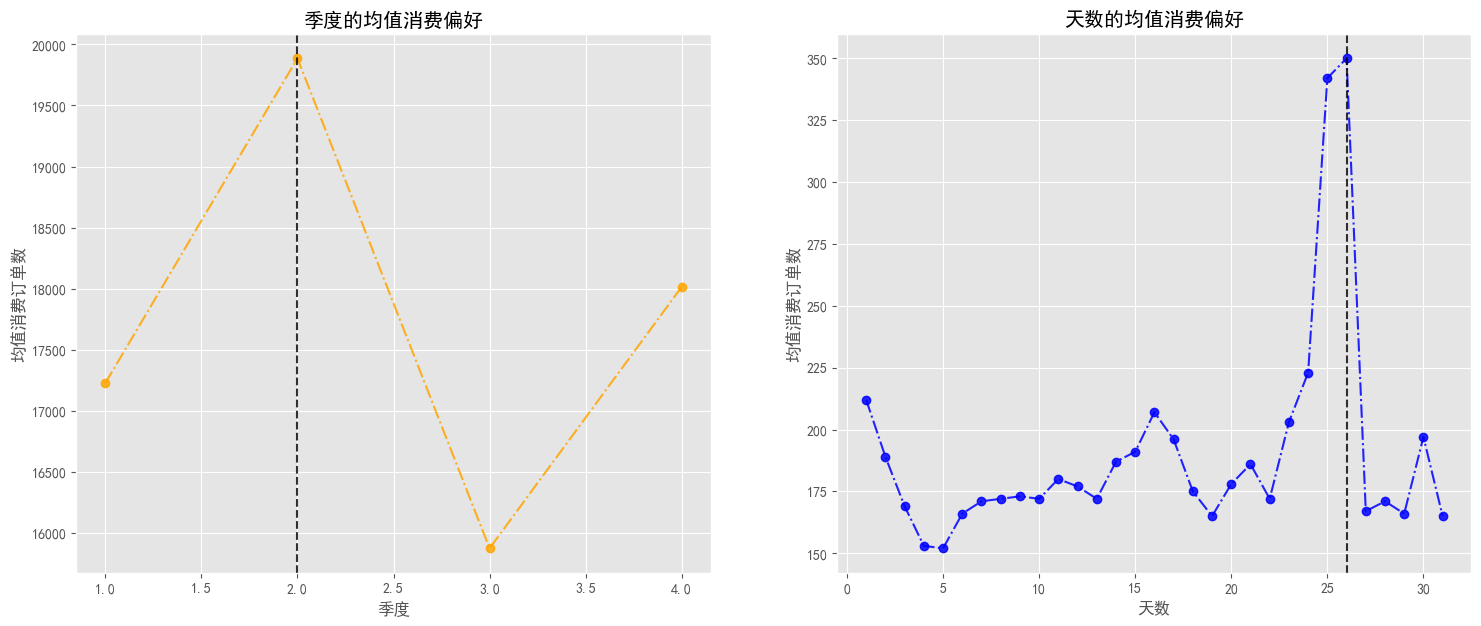

In [51]:
# 前提假设：2015-2018年之间，消费者偏好在时间上不会发生太大的变化（均值），消费偏好以不同时间的订单数来衡量
quarters_list, quarters_order = orders(df_vip, '季度', 3)
days_list, days_order = orders(df_vip, '天', 36)
time_list = [quarters_list, days_list]
order_list = [quarters_order, days_order]
maxindex_list = [quarters_order.index(max(quarters_order)), days_order.index(max(days_order))]
fig, axs = plt.subplots(1, 2, figsize = (18, 7), dpi = 100)
colors = np.random.choice(['r', 'g', 'b', 'orange', 'y'], replace = False, size = len(axs))
titles = ['季度的均值消费偏好', '天数的均值消费偏好']
labels = ['季度', '天数']
for i in range(len(axs)):
    ax = axs[i]
    ax.plot(time_list[i], order_list[i], linestyle = '-.', c = colors[i], marker = 'o', alpha = 0.85)
    ax.axvline(x = time_list[i][maxindex_list[i]], linestyle = '--', c = 'k', alpha = 0.8)
    ax.set_title(titles[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel('均值消费订单数')
    print(f'{titles[i]}最优的时间为: {time_list[i][maxindex_list[i]]}\t 对应的均值消费订单数为: {order_list[i][maxindex_list[i]]}')
plt.savefig('./季度和天数的均值消费偏好情况.png')

In [52]:
# 自定义函数来绘制不同年份之间的的季度或天数的消费订单差异
def plot_qd(df, label_y, label_m, nrow, ncol):
    """
    df: 为DataFrame的数据集
    label_y: 为年份的字段标签
    label_m: 为标签的一个列表
    n_row: 图的行数
    n_col: 图的列数
    """
    # 由于2018年数据非整年数据，必须去掉2018年的数据，只能对2015-2017年之间的数据进行分析
    y_list = np.sort(df[label_y].unique().tolist())[:-1]
    colors = np.random.choice(['r', 'g', 'b', 'orange', 'y', 'k', 'c', 'm'], replace = False, size = len(y_list))
    markers = ['o', '^', 'v']
    plt.figure(figsize = (8, 6), dpi = 100)
    fig, axs = plt.subplots(nrow, ncol, figsize = (16, 7), dpi = 100)
    for k in range(len(label_m)):
        m_list = np.sort(df[label_m[k]].unique().tolist())
        for i in range(len(y_list)):
            order_m = []
            index1 = df[label_y] == y_list[i]
            for j in range(len(m_list)):
                index2 = df[label_m[k]] == m_list[j]
                order_m.append(len(df.loc[index1 & index2, '消费产生的时间'].unique()))
            axs[k].plot(m_list, order_m, linestyle ='-.', c = colors[i], alpha = 0.8, marker = markers[i], label = y_list[i], markersize = 4)
        axs[k].set_xlabel(f'{label_m[k]}')
        axs[k].set_ylabel('消费订单数')
        axs[k].set_title(f'2015-2018年会员的{label_m[k]}消费订单差异')
        axs[k].legend()
    plt.savefig(f'./2015-2018年会员的{"和".join(label_m)}消费订单差异.png')

<Figure size 800x600 with 0 Axes>

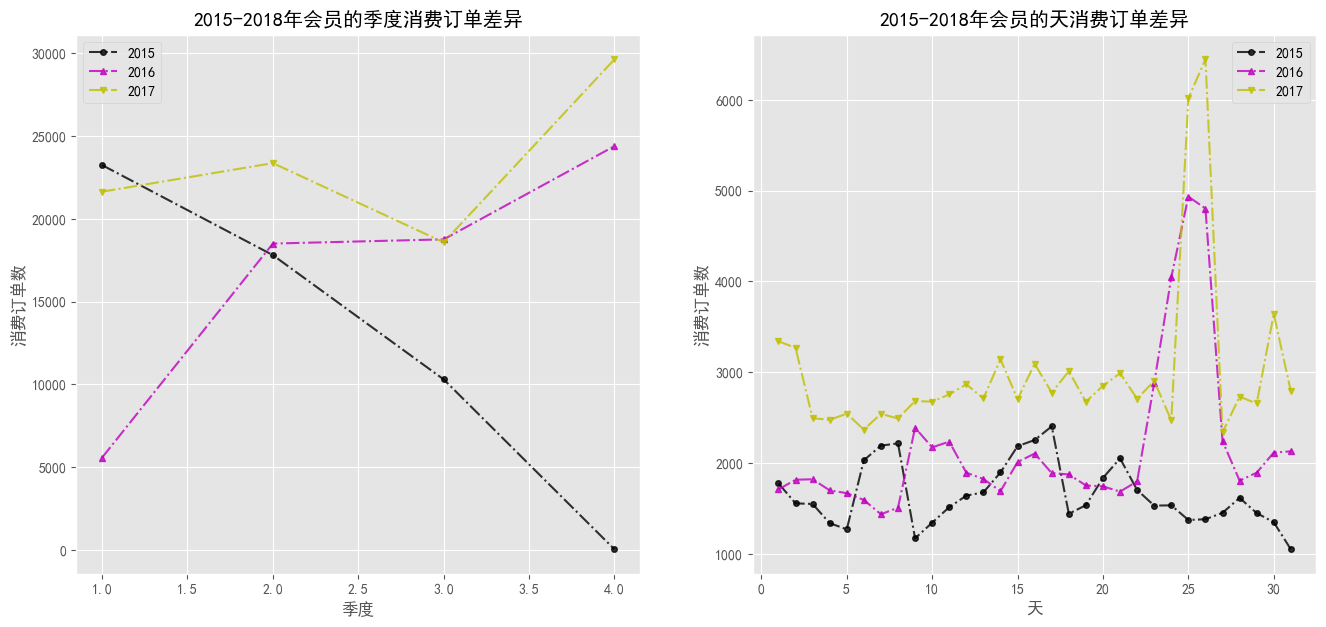

In [55]:
# 调用函数
plot_qd(df_vip, '年份', ['季度', '天'], 1, 2)

In [54]:
# 自定义函数来绘制不同年份之间的月份消费订单差异
def plot_ym(df, label_y, label_m):
    """
    df: 为DataFrame的数据集
    label_y: 为年份的字段标签
    label_m: 为月份的字段标签
    """
    # 由于2018年数据非整年数据，必须去掉2018年的数据，只能对2015-2017年之间的数据进行分析
    y_list = np.sort(df[label_y].unique().tolist())[:-1]
    m_list = np.sort(df[label_m].unique().tolist())
    colors = np.random.choice(['r', 'g', 'b', 'orange', 'y'], replace = False, size = len(y_list))
    markers = ['o', '^', 'v']
    fig, axs = plt.subplots(1, 2, figsize = (18, 8), dpi = 100)
    for i in range(len(y_list)):
        order_m = []
        money_m = []
        index1 = df[label_y] == y_list[i]
        for j in range(len(m_list)):
            index2 = df[label_m] == m_list[j]
            order_m.append(len(df.loc[index1 & index2, '消费产生的时间'].unique()))
            money_m.append(df.loc[index1 & index2, '消费金额'].sum())
        axs[0].plot(m_list, order_m, linestyle ='-.', c = colors[i], alpha = 0.8, marker = markers[i], label = y_list[i])
        axs[1].plot(m_list, money_m, linestyle ='-.', c = colors[i], alpha = 0.8, marker = markers[i], label = y_list[i])
        axs[0].set_xlabel('月份')
        axs[0].set_ylabel('消费订单数')
        axs[0].set_title('2015-2018年会员的消费订单差异')
        axs[1].set_xlabel('月份')
        axs[1].set_ylabel('消费金额总数')
        axs[1].set_title('2015-2018年会员的消费金额差异')
        axs[0].legend()
        axs[1].legend()
    plt.savefig('./2015-2018年会员的消费订单和金额差异.png')

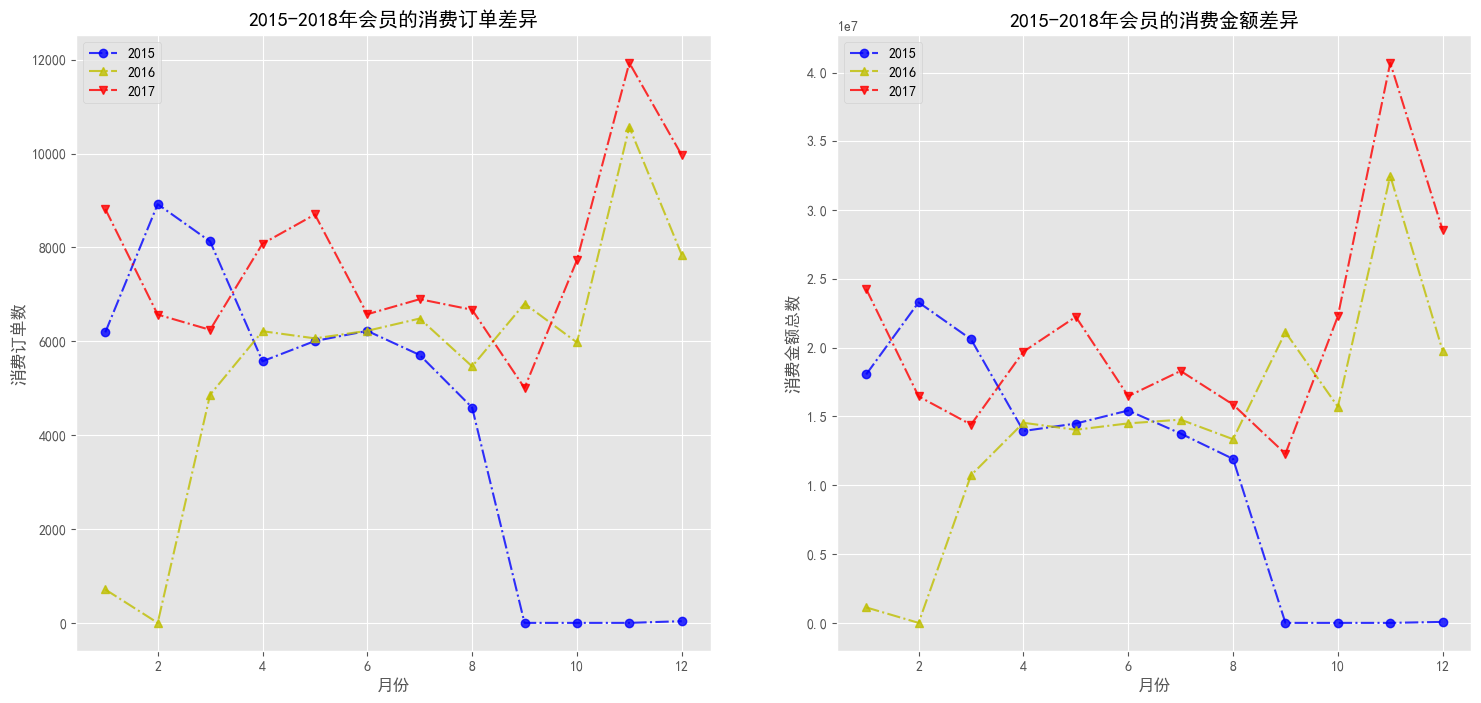

In [56]:
# 调用函数
plot_ym(df_vip, '年份', '月份')

In [57]:
# 再来分析下时间上的差差异——消费订单数
df_vip['时间'] = df_vip['消费产生的时间'].dt.hour
x_list, order_nums = orders(df_vip, '时间', 1)

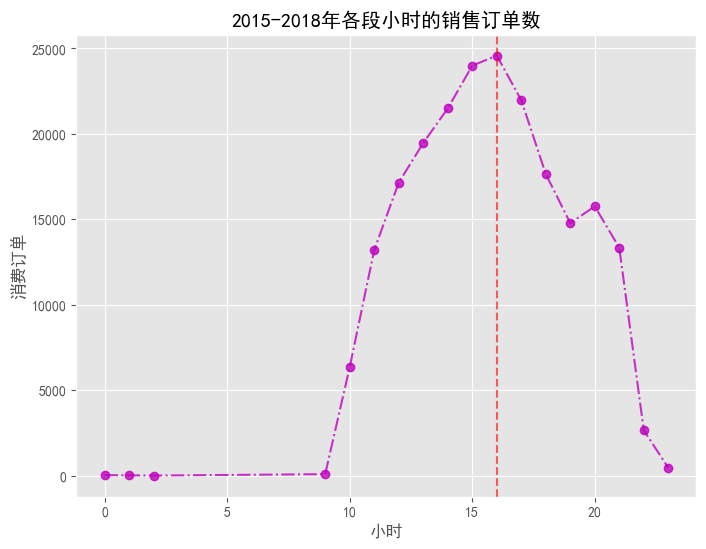

In [58]:
maxindex = order_nums.index(max(order_nums))
plt.figure(figsize = (8, 6), dpi = 100)
plt.plot(x_list, order_nums, linestyle = '-.', marker = 'o', c = 'm', alpha = 0.8)
plt.xlabel('小时')
plt.ylabel('消费订单')
plt.axvline(x = x_list[maxindex], linestyle = '--', c = 'r', alpha = 0.6)
plt.title('2015-2018年各段小时的销售订单数')
plt.savefig('./2015-2018年各段小时的销售订单数.png')

In [59]:
# 保存数据
df_vip.to_csv('vip_info.csv', encoding = 'gb18030', index = None)

# 任务4 会员用户画像和特征字段创造

## 任务4.1 构建会员用户基本特征标签

In [60]:
# 导入上面保存的数据集
df_vip = pd.read_csv('vip_info.csv', encoding = 'gbk')
df_vip

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年份,月份,季度,天,时间
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393477,826ea280,2018-01-03 21:25:16.236,2c276195,1,299.0,299.0,芭芭麻麻正价件,299.00,fcd0,0.0,2017-12-25 19:30:50.746,2018,1,1,3,21
393478,826ea280,2018-01-03 21:25:16.236,2c276195,1,399.0,399.0,芭芭麻麻正价件,399.00,fcd0,0.0,2017-12-25 19:30:50.746,2018,1,1,3,21
393479,5d761c48,2018-01-03 21:27:28.686,a1e1cc27,1,990.0,990.0,Gucci品牌 正价无,990.00,1f26,0.0,2016-11-25 15:09:06.323,2018,1,1,3,21
393480,607c7cde,2018-01-03 21:38:15.343,3bc576f1,2,480.0,960.0,植村秀腮红刷20,960.00,3d84,0.0,2017-09-02 19:44:50.123,2018,1,1,3,21


In [61]:
# 验证积分这一列没有存在异常值
print(len(df_vip['此次消费的会员积分'] > 0) == df_vip.shape[0])
len(df_vip[df_vip['消费金额'] > 0])

True


393482

In [62]:
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393482 entries, 0 to 393481
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   会员卡号       393482 non-null  object 
 1   消费产生的时间    393482 non-null  object 
 2   商品编码       393482 non-null  object 
 3   销售数量       393482 non-null  int64  
 4   商品售价       393482 non-null  float64
 5   消费金额       393482 non-null  float64
 6   商品名称       393482 non-null  object 
 7   此次消费的会员积分  393482 non-null  float64
 8   单据号        393482 non-null  object 
 9   性别         393482 non-null  float64
 10  登记时间       393482 non-null  object 
 11  年份         393482 non-null  int64  
 12  月份         393482 non-null  int64  
 13  季度         393482 non-null  int64  
 14  天          393482 non-null  int64  
 15  时间         393482 non-null  int64  
dtypes: float64(4), int64(6), object(6)
memory usage: 48.0+ MB


In [64]:
# 查看登记时间和消费产生的时间是否存在异常值，即大于2018-01-03
print('消费产生的时间存在异常值的数量为：{}\t登记时间存在的异常值数量为：{}'.format(len(df_vip[df_vip['消费产生的时间'] >= '2018-01-03']),len(df_vip[df_vip['登记时间'] >= '2018-01-03'])))

消费产生的时间存在异常值的数量为：469	登记时间存在的异常值数量为：36


In [65]:
# 筛掉两列异常时间的数据
index1 = df_vip['消费产生的时间'] < '2018-01-03'
index2 = df_vip['登记时间'] < '2018-01-03'
df_vip = df_vip[index1 & index2]
df_vip.index = range(df_vip.shape[0])
print('筛除全部异常值之后数据的记录数为：{}\t共有{}个字段'.format(df_vip.shape[0], df_vip.shape[1]))

筛除全部异常值之后数据的记录数为：393006	共有16个字段


In [66]:
# 验证单个会员有多条消费记录数
print('会员总数：{}\t 记录数：{}'.format(len(df_vip['会员卡号'].unique()), df_vip.shape[0]))
df_vip.columns

会员总数：42548	 记录数：393006


Index(['会员卡号', '消费产生的时间', '商品编码', '销售数量', '商品售价', '消费金额', '商品名称', '此次消费的会员积分',
       '单据号', '性别', '登记时间', '年份', '月份', '季度', '天', '时间'],
      dtype='object')

可以先筛选每位会员，然后依据各个字段对进行运算，求出对应的LRFMP

In [67]:
# 自定义一个函数来实现两列数据时间相减
def time_minus(df, end_time):
    """
    df: 为DataFrame形式，有两列数据，第一列为“会员卡号”，第二列为被减的时间
    end_time: 结束时间
    """
    df.columns = ['A', 'B']
    df['C'] = end_time
    l = pd.to_datetime(df['C']) - pd.to_datetime(df['B'])
    l = l.apply(lambda x: str(x).split(' ')[0])
    l = l.astype(int) / 30
    return l

In [68]:
# 开始登记的时间
df_L = df_vip.groupby('会员卡号')['登记时间'].agg(lambda x: x.values[-1]).reset_index()
# 最后一次消费的时间
df_R = df_vip.groupby('会员卡号')['消费产生的时间'].agg(lambda x: x.values[-1]).reset_index()

In [69]:
# 调用函数，end_time为“2018-1-3”
end_time = '2018-1-3'
L = time_minus(df_L, end_time)
R = time_minus(df_R, end_time)

In [70]:
# 会员消费的总次数
F = df_vip.groupby('会员卡号')['消费产生的时间'].agg(lambda x: len(np.unique(x.values))).reset_index(drop = True)
# 会员消费的总金额
M = df_vip.groupby('会员卡号')['消费金额'].agg(lambda x: np.sum(x.values)).reset_index(drop = True)
# 会员的积分总数
P = df_vip.groupby('会员卡号')['此次消费的会员积分'].agg(lambda x: np.sum(x.values)).reset_index(drop = True)

In [71]:
# 创造一列特征字段“消费时间偏好”（凌晨、上午、中午、下午、晚上）
"""
凌晨：0-5点
上午：6-10点
中午：11-13点
下午：14-17点
晚上：18-23点
"""
df_vip['消费时间偏好'] = df_vip['时间'].apply(lambda x: '晚上' if x >= 18 else '下午' if x >= 14 else '中午' 
                                      if x >= 11 else '上午' if x >= 6 else '凌晨')
df_vip

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年份,月份,季度,天,时间,消费时间偏好
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393001,5f0f5718,2018-01-02 21:09:31.703,12b9a5b7,1,330.0,330.0,圣罗兰气垫粉底芯.,330.00,8c57,1.0,2016-07-17 00:00:00.000,2018,1,1,2,21,晚上
393002,88b2d3dd,2018-01-02 21:10:36.703,3993f69b,1,1080.0,80.0,兰蔻菁眼/大黑/美丽人生15ml,80.00,4bc8,0.0,2017-03-31 00:00:00.000,2018,1,1,2,21,晚上
393003,14bc144b,2018-01-02 21:19:51.703,6c453411,1,161.0,161.0,伊维斯正价件,161.00,fcd0,0.0,2015-03-04 00:00:00.000,2018,1,1,2,21,晚上
393004,cb750c7d,2018-01-02 21:24:44.783,38b3338a,1,310.0,310.0,阿玛尼丝绒/漆光唇釉.,310.00,4bc8,0.0,2017-12-14 00:00:00.000,2018,1,1,2,21,晚上


In [72]:
# 会员消费的时间偏好，在多项记录中取众数
S = df_vip.groupby('会员卡号')['消费时间偏好'].agg(lambda x: x.mode().values[0]).reset_index(drop = True)

In [73]:
# 会员性别，取unique()
X = df_vip.groupby('会员卡号')['性别'].agg(lambda x: '女' if x.unique()[0] == 0 else '男').reset_index(drop = True)

In [74]:
# 开始构建对应的特征标签
df_i = pd.Series(df_vip['会员卡号'].unique())
df_LRFMPSX = pd.concat([df_i, L, R, F, M, P, S, X], axis = 1)
df_LRFMPSX.columns = ['id', 'L', 'R', 'F', 'M', 'P', 'S', 'X']
df_LRFMPSX.head()

,id,L,R,F,M,P,S,X
0,d8d36575,23.933333,13.433333,2,5266.5,5267.0,中午,女
1,8527d4d0,107.066667,2.066667,7,12850.0,11850.0,下午,女
2,586a3339,52.300000,0.566667,10,6340.8,6141.0,上午,女
3,c2477497,56.066667,2.266667,1,8964.0,8964.0,中午,女
4,0706d57c,18.200000,2.066667,1,236.0,236.0,上午,女


In [76]:
# 保存数据
df_LRFMPSX.to_csv('LRFMPSX.csv', encoding = 'gb18030', index = None)

### 构建会员用户业务特征标签

取DataFrame之后转置取values得到一个列表，再绘制对应的词云，可以自定义一个绘制词云的函数，输入参数为df和会员卡号

L: 入会程度（新用户、中等用户、老用户）

R: 最近购买的时间（月）

F: 消费频数（低频、中频、高频）

M: 消费总金额（高消费、中消费、低消费）

P: 积分（高、中、低）

S: 消费时间偏好（凌晨、上午、中午、下午、晚上）

X：性别（男、女）

In [82]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud

In [83]:
# 读取数据集
df = pd.read_csv('./LRFMPSX.csv', encoding = 'gbk')
df.head()

,id,L,R,F,M,P,S,X
0,d8d36575,23.933333,13.433333,2,5266.5,5267.0,中午,女
1,8527d4d0,107.066667,2.066667,7,12850.0,11850.0,下午,女
2,586a3339,52.300000,0.566667,10,6340.8,6141.0,上午,女
3,c2477497,56.066667,2.266667,1,8964.0,8964.0,中午,女
4,0706d57c,18.200000,2.066667,1,236.0,236.0,上午,女


In [84]:
# 查看数据的基本特征
print(f'数据集的shape:{df.shape}')
df.isnull().mean()

数据集的shape:(42548, 8)


id    0.0
L     0.0
R     0.0
F     0.0
M     0.0
P     0.0
S     0.0
X     0.0
dtype: float64

In [85]:
# 进行描述性统计
df.describe()

,L,R,F,M,P
count,42548.000000,42548.000000,42548.000000,4.254800e+04,4.254800e+04
mean,43.272356,12.748108,5.000917,1.314873e+04,1.166768e+04
std,38.427058,11.415613,9.963993,3.650895e+04,3.293682e+04
min,0.000000,0.000000,1.000000,7.300000e-01,8.100000e-01
25%,11.966667,2.900000,1.000000,1.424820e+03,1.250000e+03
50%,32.133333,9.433333,2.000000,3.885000e+03,3.410000e+03
75%,67.200000,19.433333,5.000000,1.106000e+04,9.345000e+03
max,185.000000,36.566667,287.000000,1.511900e+06,1.413370e+06


In [86]:
# 开始对数据进行分组
"""
L（入会程度）：3个月以下为新用户，4-12个月为中等用户，13个月以上为老用户
R（最近购买的时间）
F（消费频次）：次数20次以上的为高频消费，6-19次为中频消费，5次以下为低频消费
M（消费金额）：10万以上为高等消费，1万-10万为中等消费，1万以下为低等消费
P（消费积分）：10万以上为高等积分用户，1万-10万为中等积分用户，1万以下为低等积分用户
"""
df_profile = pd.DataFrame()
df_profile['会员卡号'] = df['id']
df_profile['性别'] = df['X']
df_profile['消费偏好'] = df['S'].apply(lambda x: '您喜欢在' + str(x) + '时间进行消费')
df_profile['入会程度'] = df['L'].apply(lambda x: '老用户' if int(x) >= 13 else '中等用户' if int(x) >= 4 else '新用户')
df_profile['最近购买的时间'] = df['R'].apply(lambda x: '您最近' + str(int(x) * 30) + '天前进行过一次购物')
df_profile['消费频次'] = df['F'].apply(lambda x: '高频消费' if x >= 20 else '中频消费' if x >= 6 else '低频消费')
df_profile['消费金额'] = df['M'].apply(lambda x: '高等消费用户' if int(x) >= 1e+05 else '中等消费用户' if int(x) >= 1e+04 else '低等消费用户')
df_profile['消费积分'] = df['P'].apply(lambda x: '高等积分用户' if int(x) >= 1e+05 else '中等积分用户' if int(x) >= 1e+04 else '低等积分用户')
df_profile

,会员卡号,性别,消费偏好,入会程度,最近购买的时间,消费频次,消费金额,消费积分
0,d8d36575,女,您喜欢在中午时间进行消费,老用户,您最近390天前进行过一次购物,低频消费,低等消费用户,低等积分用户
1,8527d4d0,女,您喜欢在下午时间进行消费,老用户,您最近60天前进行过一次购物,中频消费,中等消费用户,中等积分用户
2,586a3339,女,您喜欢在上午时间进行消费,老用户,您最近0天前进行过一次购物,中频消费,低等消费用户,低等积分用户
3,c2477497,女,您喜欢在中午时间进行消费,老用户,您最近60天前进行过一次购物,低频消费,低等消费用户,低等积分用户
4,0706d57c,女,您喜欢在上午时间进行消费,老用户,您最近60天前进行过一次购物,低频消费,低等消费用户,低等积分用户
...,...,...,...,...,...,...,...,...
42543,406380bf,女,您喜欢在晚上时间进行消费,中等用户,您最近270天前进行过一次购物,低频消费,低等消费用户,低等积分用户
42544,4f7fa021,女,您喜欢在晚上时间进行消费,新用户,您最近30天前进行过一次购物,低频消费,低等消费用户,低等积分用户
42545,14a60aea,男,您喜欢在晚上时间进行消费,老用户,您最近570天前进行过一次购物,低频消费,低等消费用户,低等积分用户
42546,139ddf73,女,您喜欢在下午时间进行消费,老用户,您最近330天前进行过一次购物,中频消费,中等消费用户,中等积分用户


In [87]:
# 保存数据
df_profile.to_csv('./consumers_profile.csv', encoding = 'gb18030', index = None)

## 任务4.2 会员用户词云分析

In [88]:
# 开始绘制用户词云，封装成一个函数来直接显示词云
def wc_plot(df, id_label = None):
    """
    df: 为DataFrame的数据集
    id_label: 为输入用户的会员卡号，默认为随机取一个会员进行展示
    """
    myfont = 'C:/Windows/Fonts/simkai.ttf'
    if id_label == None:
        id_label = df.loc[np.random.choice(range(df.shape[0])), '会员卡号']
    text = df[df['会员卡号'] == id_label].T.iloc[:, 0].values.tolist()
    plt.figure(dpi = 100)
    wc = WordCloud(font_path = myfont, background_color = 'white', width = 500, height = 400).generate_from_text(' '.join(text))
    plt.imshow(wc)
    plt.axis('off')
    plt.savefig(f'./会员卡号为{id_label}的用户画像.png')
    plt.show()

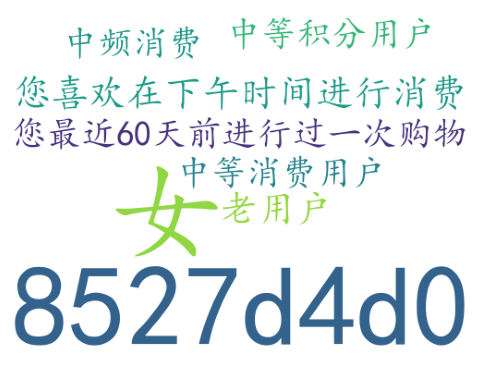

In [89]:
# 调用词云函数来绘制用户画像
wc_plot(df_profile, '8527d4d0')

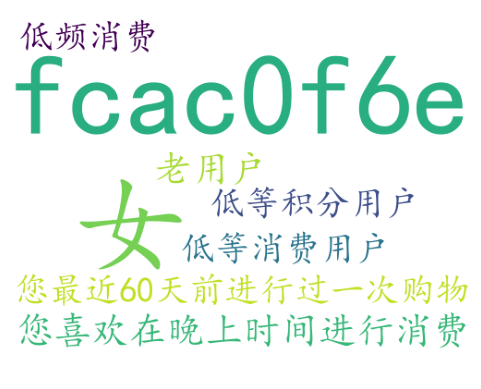

In [90]:
# 随机查找一个会员来绘制用户画像
wc_plot(df_profile)

# 任务5 会员用户细分和营销方案制定

## 任务5.1 会员用户的聚类分析及可视化

In [94]:
# 先对数据进行标准化处理
df0 = df.iloc[:, 1:6]
res_std = StandardScaler().fit_transform(df0)

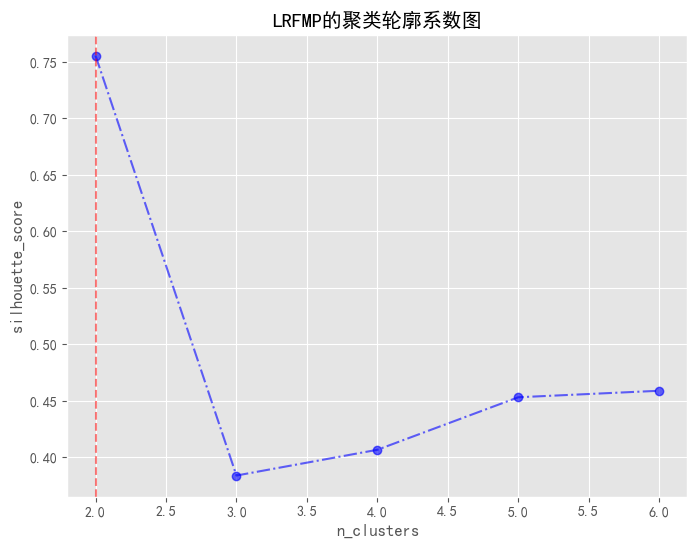

In [95]:
# 对数据进行聚类
n_clusters = range(2, 7)
scores = []
for i in range(len(n_clusters)):
    clf = KMeans(n_clusters = n_clusters[i], random_state = 20).fit(res_std)
    scores.append(silhouette_score(res_std, clf.labels_))
maxindex = scores.index(max(scores))
plt.figure(figsize = (8, 6), dpi = 100) 
plt.plot(n_clusters, scores, linestyle = '-.', c = 'b', alpha = 0.6, marker = 'o')
plt.axvline(x = n_clusters[maxindex], linestyle = '--', c = 'r', alpha = 0.5)
plt.title('LRFMP的聚类轮廓系数图')
plt.ylabel('silhouette_score')
plt.xlabel('n_clusters')
plt.savefig('./LRFMP聚类轮廓系数图.png')

In [96]:
# 构造一个绘制聚类可视化效果雷达图的函数
def plot(features, clf_list, nrow, ncol, title):
    """
    features: 字段名
    clf_list：list，为聚类器列表
    nrow: 图的行数
    ncol: 图的列数
    title: 图的名称
    """
    N = len(features)
    angles = np.linspace(0, 2 * np.pi, N, endpoint = False)
    angles = np.concatenate([angles, [angles[0]]])
    features = np.concatenate([features, [features[0]]])
    fig = plt.figure(figsize = (14, 14), dpi = 100)
    for i in range(len(clf_list)):
        clf = clf_list[i]
        centers = clf.cluster_centers_
        # add_subplot的index从1开始
        ax = fig.add_subplot(nrow, ncol, i + 1, polar = True)
        ax.set_thetagrids(angles * 180 / np.pi, features)
        # 随机取不同的颜色
        colors = np.random.choice(['r', 'g', 'b', 'y', 'k', 'orange'], replace = False, size = len(centers))
        for j in range(len(centers)):
            values = np.concatenate([centers[j, :], [centers[j, :][0]]])
            ax.plot(angles, values, c = colors[j], alpha = 0.6, linestyle = '-.', label = '类别' + str(j + 1))
            ax.fill(angles, values, c = colors[j], alpha = 0.2)
        ax.set_title(f'n_clusters = {len(centers)}')
        ax.legend()
    plt.suptitle(title)
    plt.savefig(f'./{title}.png')

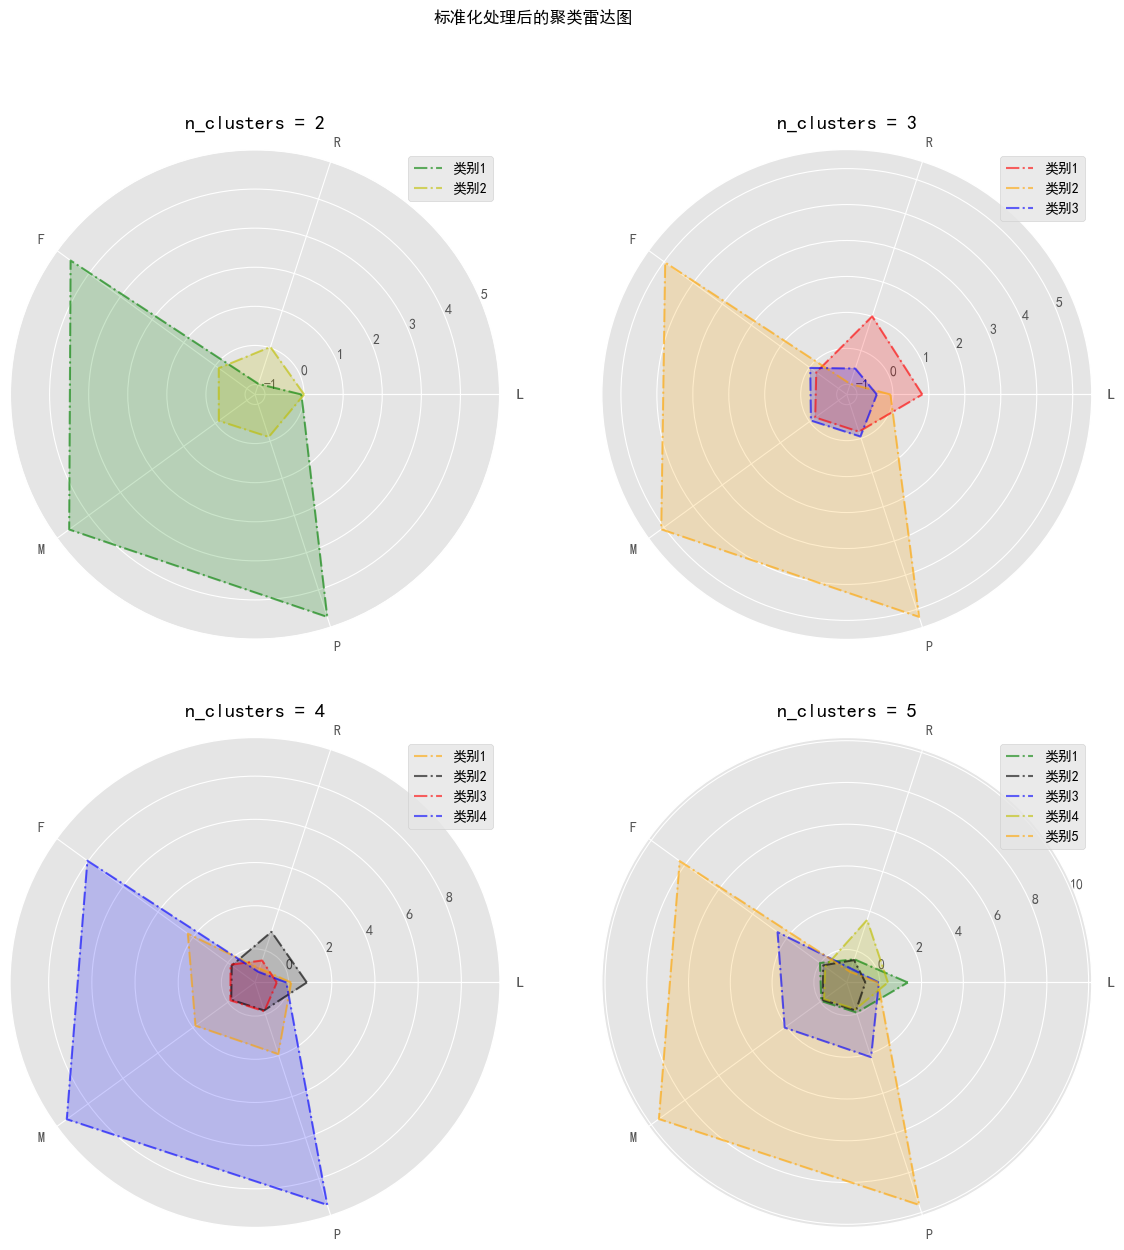

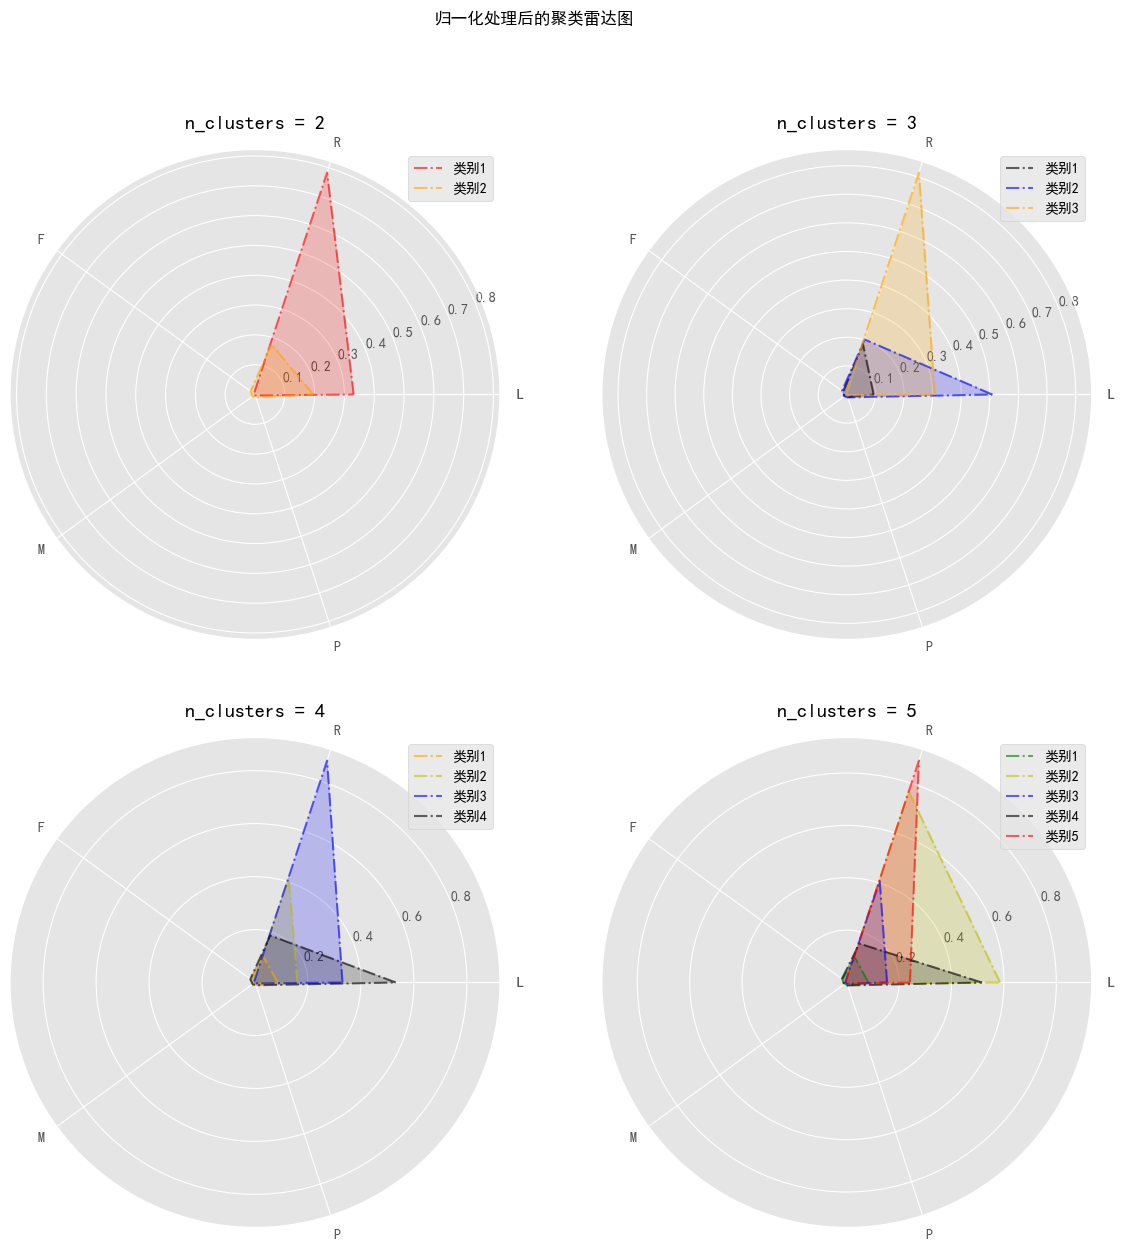

In [97]:
features = list('LRFMP')
res_std = StandardScaler().fit_transform(df0)
res_mm = MinMaxScaler().fit_transform(df0)
res = [res_std, res_mm]
titles = ['标准化处理后的聚类雷达图', '归一化处理后的聚类雷达图']
for i in range(len(res)):
    clf = []
    for j in range(2, 6):
        clf.append(KMeans(n_clusters = j, random_state = 20).fit(res[i]))
    plot(features, clf, 2, 2, titles[i])

从上面可以看出，标准化后的数据聚类效果相较于归一化的更好，且从轮廓系数和聚类雷达图也可以看出，聚类数最佳为2。因此，下面我们使用聚类数为2的标准化数据进行聚类，得到两类客户的LRFMP均值数据，以此来判断两者之间的差异

## 任务5.2 对会员用户进行精细划分并分析不同群体带来的价值差异

In [98]:
# 以聚类数为2贴上对应的标签
clf = KMeans(n_clusters = 2, random_state = 20).fit(res_std)
df0['labels'] = clf.labels_
df0

,L,R,F,M,P,labels
0,23.933333,13.433333,2,5266.5,5267.0,1
1,107.066667,2.066667,7,12850.0,11850.0,1
2,52.300000,0.566667,10,6340.8,6141.0,1
3,56.066667,2.266667,1,8964.0,8964.0,1
4,18.200000,2.066667,1,236.0,236.0,1
...,...,...,...,...,...,...
42543,9.333333,9.333333,1,300.0,300.0,1
42544,1.166667,1.166667,1,5530.0,5530.0,1
42545,57.433333,19.700000,2,7139.0,7139.0,1
42546,80.966667,11.600000,12,11712.0,11712.0,1


In [99]:
# 统计一下两类用户之间的差异，发现两类客户之间数量相差过大
print(f"类别0所占比例为：{df0['labels'].value_counts().values[0] / df0.shape[0]} \t 类别1所占的比例为：{df0['labels'].value_counts().values[1] / df0.shape[0]}")
df0['labels'].value_counts()

类别0所占比例为：0.9766381498542822 	 类别1所占的比例为：0.023361850145717778


labels
1    41554
0      994
Name: count, dtype: int64

In [100]:
# 用均值来计算两类样本之间的LRFMP
L_avg = df0.groupby('labels').agg({'L': np.mean}).reset_index()
R_avg = df0.groupby('labels').agg({'R': np.mean}).reset_index()
F_avg = df0.groupby('labels').agg({'F': np.mean}).reset_index()
M_avg = df0.groupby('labels').agg({'M': np.mean}).reset_index()
P_avg = df0.groupby('labels').agg({'P': np.mean}).reset_index()

In [101]:
# 绘制相关的条形图
def plot_bar(df_list, nrow, ncol):
    fig, axs = plt.subplots(nrow, ncol, figsize = (2 * (ncol + 2), 2.5), dpi = 100)
    for i in range(len(axs)):
        ax = axs[i]
        df = df_list[i]
        ax.bar(df.iloc[:, 0], df.iloc[:, 1], color = 'm', alpha = 0.4, width = 0.5)
        for x, y in enumerate(df.iloc[:, 1].tolist()):
            ax.text(x, y / 2, '%.0f' % y, va = 'bottom', ha = 'center', fontsize = 12)
        ax.set_xticks([0, 1])
        ax.set_yticks(())
        ax.set_title(f'{df.columns[1]}')
    plt.suptitle('两类客户的LRFMP均值差异', y = 1.1, fontsize = 14)
    plt.savefig('./两类客户的LRFMP均值差异.png')

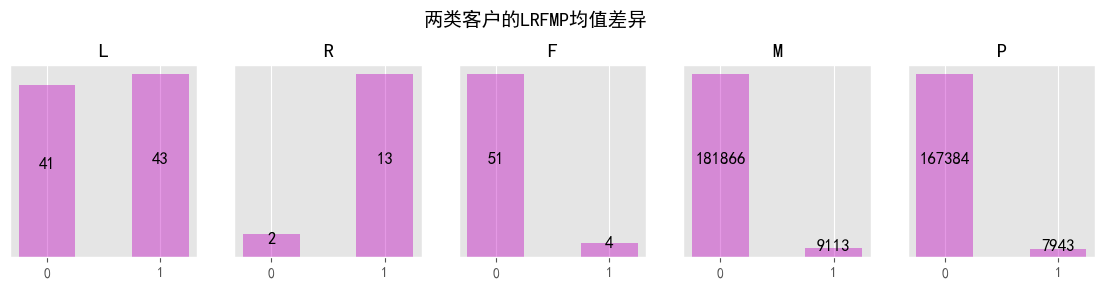

In [102]:
df_list = [L_avg, R_avg, F_avg, M_avg, P_avg]
plot_bar(df_list, 1, 5)

从上面可以看出，标签为0的客户消费频次、消费金额和消费积分均远大于标签为1的客户，且这类客户所占的比例仅有2.3%，可以将其定义为“重要保持会员”。标签为1的客户所占比例为97.7%，其会员登记时间跟标签为0的比较接近，但最近一次消费时间较标签0的还要长，可以将其定义为“一般发展会员”